# EDA of Drinking Water Quality Testing in Palm Beach County from 2019 through 2023
## Exploratory data analysis with visualizations

In this EDA, we will look at results of tests of drinking water sampled around Palm Beach County from 2019 through 2023. This data comes from the Drinking Water Database managed by the Florida Department of Environmental Protection (DEP). It can be accessed here: https://floridadep.gov/water/source-drinking-water/content/information-drinking-water-database

The following information about the Florida DEP and their Drinking Water Database is copied from their website:
"The Department of Environmental Protection has the primary role of regulating public water systems in Florida... A public water system is one that provides water to 25 or more people for at least 60 days each year or serves 15 or more service connections. These public water systems may be publicly or privately owned and operated."

The Drinking Water Database includes "information on sample results, average/max monthly flows, types of water treatment, the type of system, address, capacity, sources of water, population and service connections served, dates the department performed the last sanitary survey, and the dates the last bacteria and inorganic/organic contaminant testing was performed." This information is available in five distinct reports, which the DEP has named "Basic Facility Reports," "Chemical Data," "Microbiological Data," "Flow Data," and "Plant Treatment Data."

In [ ]:
# iframe to website as visualization?

After exploring the website and looking at some of the reports, I decided to focus this EDA on levels of contaminants in the drinking water tests. There are dozens of germs and chemicals that could contaminate our drinking water. According to the United States Center for Disease Control, the chemicals that most often contaminate tap water and cause disease are Arsenic, Copper, Lead, Nitrate, and Radon (https://www.cdc.gov/healthywater/drinking/contamination/chemicals.html). We will look at Arsenic, Copper, Lead, and Nitrate levels in drinking water around Palm Beach County, Florida. For the rest of this analysis, I will refer to these four chemicals as our contaminants of interest.

Results of testing for our contaminants of interest are available in the Florida DEP's "Chemical Data" reports. The chemical data includes test results for locations in all of Florida, identified in the table by a "Public Water System Identification Number" (PWS ID). In order to identify the water system locations in our county of interest, Palm Beach, we will need to cross-reference PWS IDs in the chemical data with those in the "Basic Facility Reports," which provides data on those Public Water Systems. This will allow us to narrow down the chemical data to records in our county. 

First, I load the DEP's most recent facility report, which has a column for "County." This makes filtering PWS IDs by County very simple!

In [ ]:
import pandas as pd

# Filter PWS IDs for those located in my county - "PALM BEACH"
def clean_data(df):
    df = df[df["COUNTY"] == "PALM BEACH"]
    return df

# Loaded variable 'df' from URI: /Users/user/Documents/DSPT14/Individual Project/data/FacilityReport_2023_0.csv
fac_df = pd.read_csv(r'/Users/user/Documents/DSPT14/Individual Project/data/FacilityReport_2023_0.csv')

fac_df_clean = clean_data(fac_df.copy())
fac_df_clean.head()

,DISTRICT,COUNTY,OFFICE,EMAIL,PWSID,SYSTEMTYPE,CATEGORYCLASS,SURFACESOURCE,GROUNDSOURCE,MAILINGNAME,...,OWNERPHONE,OWNERPHONEEXT,OWNERTYPE,POPULATIONSERVED,DESIGNCAPACITY,SERVICECONNECTIONS,LASTINSPECTION,LASTSANITARYSURVEY,FEEGROUPCODE,ANNUALFEE
2764,4,PALM BEACH,SEPB,kberroteran@wellingtonfl.gov,4500014,COMMUNITY,"CONVENTIONAL FILTRATION (COAGULATION, FLOCCULA...",N,Y,WELLINGTON WTP,...,5.617914e+09,NaN,MUNICIPALITY,56475,12800000,20747,21-Jun-22,28-Apr-22,DC01,6000
2765,4,PALM BEACH,SEPB,henry_lue@equitylifestyle.com,4500062,COMMUNITY,"CONVENTIONAL FILTRATION (COAGULATION, FLOCCULA...",N,Y,MARALAGO CAY MHP,...,8.132827e+09,NaN,INVESTOR,1200,420000,603,18-May-21,18-Mar-21,DC04,1000
2766,4,PALM BEACH,SEPB,bmoree@atlantisfl.gov,4500068,COMMUNITY,NO TREATMENT--CONSECUTIVE SYSTEMS ONLY,N,Y,"ATLANTIS, CITY OF",...,5.619652e+09,NaN,INVESTOR,3000,1440000,1644,14-May-21,18-Mar-21,PC02,100
2767,4,PALM BEACH,SEPB,marie@bedners.com,4500101,NONCOMMUNITY,CHLORINATION; AERATION FOR REMOVAL OF ANY SECO...,N,Y,BEDNER LABOR CAMP,...,5.616837e+09,NaN,INVESTOR,28,28000,1,27-Feb-22,24-Jan-22,NC01,50
2768,4,PALM BEACH,SEPB,Matthew_Capone@floridacrystals.com,4500119,NONTRANSIENT NONCOMMUNITY,"MEMBRANE PROCESSES, INCLUDING ELECTRODIALYSIS,...",N,Y,NEW HOPE SOUTH INC ( SUGAR FARMS ),...,5.619969e+09,NaN,INVESTOR,50,7000,8,24-Jan-23,7-Dec-22,NTNC,100


Our cleaned and filtered facility dataframe includes the PWS IDs for Palm Beach County, as well as street addresses for those PWS locations. We can use the street addresses to get latitude and longitude data for those locations, which will allow us to create map visualizations with our data. According to Geocod.io, "Geocoding is the process of converting addresses to latitude and longitude coordinates (i.e. GPS coordinates) so that a computer can understand them." Geocod.io is a geocoding and reverse-geocoding website that supports uploads of spreadsheets with US or Canadian addresses or coordinates and returns coordinates or approximate addresses, respecitvely. I used Geocod.io to geocode the addresses in the facility dataframe.

I wrote the facility dataframe to a csv file I'll call location data. I then uploaded that csv to geocode.io. Geocod.io merged a "Latitude" and "Longitude" column to the location data and returned a new csv file. I upload that csv in the next cell.

In [ ]:
# I uploaded the address data csv to geocod.io to add latitude and longitude data for mapping purposes
# Load new address and location data
loc_df = pd.read_csv(r'/Users/user/Documents/DSPT14/Individual Project/data/lat_long_locations.csv')

In [ ]:
# Create lists for filtering and cleaning data

# PW IDs for PALM BEACH County
palm_beach_pwsids = []
for facility in fac_df_clean["PWSID"]:
    if facility in palm_beach_pwsids:
        pass
    else: palm_beach_pwsids.append(facility)
print(palm_beach_pwsids)

# Contaminants we want to see results for
contaminants = ["ARSENIC", "COPPER", "NITRATE", "LEAD"]

# Standardize column names
column_names = ["PWSID", "CONTAMCODE", "CONTAMDESC", "RESULTS", "UOM", "MCL", "SAMPLEDATE"]

[4500014, 4500062, 4500068, 4500101, 4500119, 4500130, 4500145, 4500264, 4500351, 4500450, 4500455, 4500466, 4500530, 4500560, 4500565, 4500609, 4500634, 4500717, 4500773, 4500784, 4500840, 4500841, 4501039, 4501058, 4501104, 4501124, 4501229, 4501438, 4501491, 4501520, 4501528, 4501559, 4501640, 4501652, 4501683, 4504043, 4504097, 4504140, 4504223, 4504272, 4504285, 4504287, 4504362, 4504393, 4504396, 4504462, 4504516, 4504521, 4504522, 4504529, 4504530, 4504533, 4504664, 4504696, 4504712, 4504718, 4504903, 4504969, 4504974, 4504996, 4504998, 4504999, 4505001, 4505002, 4505005, 4505006, 4505008, 4505009, 4505010, 4505012, 4505013, 4505014, 4505017, 4505018, 4505019, 4505020]


In [ ]:
# Clean and filter chem2019 data
def clean_chem2019_data(df):    
    df = df[df["Code Description"].isin(contaminants)]
    df = df[df["PWS Number"].isin(palm_beach_pwsids)]
    df = df[["PWS Number", "Contam Code", "Code Description", "Results ", "Unit of Measure", "MCL", "Sample Date"]]
    for i in range(0, len(column_names)):
                   df = df.rename(columns={df.columns[i]:column_names[i]})
                   i += 1
    df = df.reset_index(drop=True)
    return df

chem2019_df = pd.read_csv(r'/Users/user/Documents/DSPT14/Individual Project/data/ChemReport_2019.csv')

chem2019_df_clean = clean_chem2019_data(chem2019_df.copy())
chem2019_df_clean.head()

,PWSID,CONTAMCODE,CONTAMDESC,RESULTS,UOM,MCL,SAMPLEDATE
0,4500014,1040,NITRATE,0,MG/L,10,01/10/2019
1,4500062,1040,NITRATE,1,MG/L,10,12/04/2019
2,4500101,1040,NITRATE,0,MG/L,10,12/10/2019
3,4500119,1005,ARSENIC,0,MG/L,0,08/20/2019
4,4500119,1030,LEAD,0,MG/L,0,08/20/2019


In [ ]:
# Clean and filter chem2020 data
def clean_chem2020_data(df):
    df = df[df["CONTAM DESC"].isin(contaminants)]
    df = df[df["PWS ID"].isin(palm_beach_pwsids)]
    df = df[["PWS ID", "CONTAM CODE ", "CONTAM DESC", "RESULTS", "UOM", "MCL", "SAMPLE DATE"]]
    for i in range(0, len(column_names)):
                   df = df.rename(columns={df.columns[i]:column_names[i]})
                   i += 1
    df = df.reset_index(drop=True)
    return df

chem2020_df = pd.read_csv(r'/Users/user/Documents/DSPT14/Individual Project/data/chem2020.csv')

chem2020_df_clean = clean_chem2020_data(chem2020_df.copy())
chem2020_df_clean.head()

/var/folders/sl/mv8yjf9108790gsptkrpqx3w0000gn/T/ipykernel_758/3895510056.py:12: DtypeWarning: Columns (25,27,31) have mixed types. Specify dtype option on import or set low_memory=False.
  chem2020_df = pd.read_csv(r'/Users/user/Documents/DSPT14/Individual Project/data/chem2020.csv')


,PWSID,CONTAMCODE,CONTAMDESC,RESULTS,UOM,MCL,SAMPLEDATE
0,4500014,1040,NITRATE,0.00,MG/L,10.4999,1/2/2020
1,4500014,1005,ARSENIC,0.00,MG/L,0.0104,1/2/2020
2,4500014,1030,LEAD,0.00,MG/L,0.0154,1/2/2020
3,4500014,1022,COPPER,0.00,MG/L,1.4999,1/2/2020
4,4500062,1040,NITRATE,0.19,MG/L,10.4999,8/19/2020


In [ ]:
# Clean and filter chem2021 data
def clean_chem2021_data(df):
    df = df[df["Contam Desc"].isin(contaminants)]
    df = df[df["PWSID"].isin(palm_beach_pwsids)]
    df = df[["PWSID", "Contam Code", "Contam Desc", "Results", "UOM", "MCL", "Sample Date"]]
    for i in range(0, len(column_names)):
                   df = df.rename(columns={df.columns[i]:column_names[i]})
                   i += 1
    df = df.reset_index(drop=True)
    return df

chem2021_df = pd.read_csv(r'/Users/user/Documents/DSPT14/Individual Project/data/chem2021.csv')

chem2021_df_clean = clean_chem2021_data(chem2021_df.copy())
chem2021_df_clean.head()

,PWSID,CONTAMCODE,CONTAMDESC,RESULTS,UOM,MCL,SAMPLEDATE
0,4500014,1040,NITRATE,0.00,MG/L,10.4999,28-JAN-21
1,4500062,1040,NITRATE,0.29,MG/L,10.4999,21-OCT-21
2,4500062,1030,LEAD,0.00,MG/L,0.0154,21-OCT-21
3,4500062,1005,ARSENIC,0.00,MG/L,0.0104,21-OCT-21
4,4500062,1022,COPPER,0.00,MG/L,1.4999,21-OCT-21


In [ ]:
# Clean and filter chem2022 data
def clean_chem2022_data(df):
    df = df[df["CONTAMDESC"].isin(contaminants)]
    df = df[df["PWSID"].isin(palm_beach_pwsids)]
    df = df[["PWSID", "CONTAMCODE", "CONTAMDESC", "RESULTS", "UOM", "MCL", "SAMPLEDATE"]]
    df = df.reset_index(drop=True)
    return df

# Loaded variable 'df' 
chem2022_df = pd.read_csv(r'/Users/user/Documents/DSPT14/Individual Project/data/chem2022.csv')

chem2022_df_clean = clean_chem2022_data(chem2022_df.copy())
chem2022_df_clean.head()

,PWSID,CONTAMCODE,CONTAMDESC,RESULTS,UOM,MCL,SAMPLEDATE
0,4500014,1040,NITRATE,0.000,MG/L,10.4999,20-JAN-22
1,4500014,1040,NITRATE,0.000,MG/L,10.4999,10-FEB-22
2,4500062,1040,NITRATE,0.054,MG/L,10.4999,09-DEC-22
3,4500068,1030,LEAD,0.000,MG/L,0.0154,21-DEC-22
4,4500068,1022,COPPER,0.460,MG/L,1.5499,21-DEC-22


In [ ]:
# Clean and filter chem2023 data
def clean_chem2023_data(df):
    df = df[df["CONTAMDESC"].isin(contaminants)]
    df = df[df["PWSID"].isin(palm_beach_pwsids)]
    df = df[["PWSID", "CONTAMCODE", "CONTAMDESC", "RESULTS", "UOM", "MCL", "SAMPLEDATE"]]
    df = df.reset_index(drop=True)
    return df

# Loaded variable 'df' from URI: /Users/user/Documents/DSPT14/Individual Project/data/ChemReport_2023_0.csv
chem2023_df = pd.read_csv(r'/Users/user/Documents/DSPT14/Individual Project/data/ChemReport_2023_0.csv')

chem2023_df_clean = clean_chem2023_data(chem2023_df.copy())
chem2023_df_clean.head()

,PWSID,CONTAMCODE,CONTAMDESC,RESULTS,UOM,MCL,SAMPLEDATE
0,4500014,1005,ARSENIC,0.000,MG/L,0.0104,26-Jan-23
1,4500014,1030,LEAD,0.000,MG/L,0.0154,26-Jan-23
2,4500014,1040,NITRATE,0.000,MG/L,10.4999,26-Jan-23
3,4500014,1022,COPPER,0.004,MG/L,1.4999,26-Jan-23
4,4500062,1040,NITRATE,0.440,MG/L,10.4999,18-Dec-23


In [ ]:
# Concatenate data from all years into single dataframe

frames = [chem2019_df_clean, chem2020_df_clean, chem2021_df_clean, chem2022_df_clean, chem2023_df_clean]
data = pd.concat(frames)
data = data.reset_index(drop=True)
data.shape


(996, 7)

In [ ]:
# Standardize date format
data["SAMPLEDATE"] = pd.to_datetime(data["SAMPLEDATE"], format='mixed')
data["SAMPLEDATE"] = data["SAMPLEDATE"].dt.date

In [ ]:
data[data["RESULTS"] > data["MCL"]]

,PWSID,CONTAMCODE,CONTAMDESC,RESULTS,UOM,MCL,SAMPLEDATE
183,4500773,1030,LEAD,0.19,MG/L,0.0154,2020-02-07


In [ ]:
loc_df[loc_df["PWSID"] == 4500773]

,Unnamed: 0,PWSID,MAILINGNAME,ADDRESS1,ADDRESS2,CITY,SYSTEMSTATE,ZIP,ZIPFOUR,Latitude,...,Number,Street,Unit Type,Unit Number,City,State,County,Zip,Country,Source
18,2782,4500773,LAKE WORTH BEACH UTILITIES,1900 2ND AVE NORTH,NaN,LAKE WORTH BEACH,FL,33461,4298.0,26.61919,...,1900.0,2nd Ave N,NaN,NaN,Lake Worth Beach,FL,Palm Beach County,33461,US,Palm Beach (Public Domain Palm Beach County)


In [ ]:
data[(data["PWSID"] == 4500773) & (data["CONTAMDESC"] == "LEAD")]

,PWSID,CONTAMCODE,CONTAMDESC,RESULTS,UOM,MCL,SAMPLEDATE
24,4500773,1030,LEAD,0.00,MG/L,0.0000,2019-02-15
183,4500773,1030,LEAD,0.19,MG/L,0.0154,2020-02-07
501,4500773,1030,LEAD,0.00,MG/L,0.0154,2021-05-21
582,4500773,1030,LEAD,0.00,MG/L,0.0154,2021-02-23
622,4500773,1030,LEAD,0.00,MG/L,0.0154,2021-08-26
755,4500773,1030,LEAD,0.00,MG/L,0.0154,2022-03-22
883,4500773,1030,LEAD,0.00,MG/L,0.0154,2023-03-16


In [ ]:
# Add MCLs and MCL goals according to EPA to data. From https://www.epa.gov/ground-water-and-drinking-water/national-primary-drinking-water-regulations
# Define function to make MCL assignment
def epa_mcl(contaminant):
    if contaminant == "LEAD":
        return 0.015
    if contaminant == "ARSENIC":
        return 0.010
    if contaminant == "NITRATE":
        return 10
    if contaminant == "COPPER":
        return 1.3
    
# Define function to make MCL goal assignment
def epa_mclg(contaminant):
    if contaminant == "LEAD":
        return 0
    elif contaminant == "ARSENIC":
        return 0
    elif contaminant == "NITRATE":
        return 10
    elif contaminant == "COPPER":
        return 1.3
    
# Apply above fuctions to CONTAMDESC column to create two new columns, EPA_MCL and EPA_MCLG
data["EPA_MCL"] = data["CONTAMDESC"].apply(epa_mcl)
data["EPA_MCLG"] = data["CONTAMDESC"].apply(epa_mclg)

data.head(20)

,PWSID,CONTAMCODE,CONTAMDESC,RESULTS,UOM,MCL,SAMPLEDATE,EPA_MCL,EPA_MCLG
0,4500014,1040,NITRATE,0.0,MG/L,10.0,2019-01-10,10.000,10.0
1,4500062,1040,NITRATE,1.0,MG/L,10.0,2019-12-04,10.000,10.0
2,4500101,1040,NITRATE,0.0,MG/L,10.0,2019-12-10,10.000,10.0
3,4500119,1005,ARSENIC,0.0,MG/L,0.0,2019-08-20,0.010,0.0
4,4500119,1030,LEAD,0.0,MG/L,0.0,2019-08-20,0.015,0.0
5,4500119,1040,NITRATE,0.0,MG/L,10.0,2019-08-20,10.000,10.0
6,4500119,1040,NITRATE,0.0,MG/L,10.0,2019-08-20,10.000,10.0
7,4500130,1040,NITRATE,0.0,MG/L,10.0,2019-02-05,10.000,10.0
8,4500145,1040,NITRATE,0.0,MG/L,10.0,2019-01-15,10.000,10.0
9,4500145,1040,NITRATE,0.0,MG/L,10.0,2019-01-15,10.000,10.0


In [ ]:
data[data["RESULTS"] > data["EPA_MCL"]]

,PWSID,CONTAMCODE,CONTAMDESC,RESULTS,UOM,MCL,SAMPLEDATE,EPA_MCL,EPA_MCLG
183,4500773,1030,LEAD,0.19,MG/L,0.0154,2020-02-07,0.015,0.0


In [ ]:
data[data["RESULTS"] > data["EPA_MCLG"]]

,PWSID,CONTAMCODE,CONTAMDESC,RESULTS,UOM,MCL,SAMPLEDATE,EPA_MCL,EPA_MCLG
183,4500773,1030,LEAD,0.1900,MG/L,0.0154,2020-02-07,0.015,0.0
362,4500784,1005,ARSENIC,0.0002,MG/L,0.0104,2020-12-02,0.010,0.0
363,4500784,1030,LEAD,0.0062,MG/L,0.0154,2020-12-02,0.015,0.0
412,4501559,1005,ARSENIC,0.0005,MG/L,0.0104,2020-01-09,0.010,0.0
427,4504393,1030,LEAD,0.0017,MG/L,0.0154,2020-05-06,0.015,0.0
640,4501039,1030,LEAD,0.0004,MG/L,0.0154,2021-04-09,0.015,0.0
670,4504272,1030,LEAD,0.0013,MG/L,0.0154,2021-12-17,0.015,0.0
672,4504272,1030,LEAD,0.0004,MG/L,0.0154,2021-12-17,0.015,0.0
719,4500119,1030,LEAD,0.0001,MG/L,0.0154,2022-11-17,0.015,0.0
721,4500119,1005,ARSENIC,0.0004,MG/L,0.0104,2022-11-17,0.010,0.0


In [ ]:
data.isnull().values.any()

False

In [ ]:
data.head(20)

,PWSID,CONTAMCODE,CONTAMDESC,RESULTS,UOM,MCL,SAMPLEDATE,EPA_MCL,EPA_MCLG
0,4500014,1040,NITRATE,0.0,MG/L,10.0,2019-01-10,10.000,10.0
1,4500062,1040,NITRATE,1.0,MG/L,10.0,2019-12-04,10.000,10.0
2,4500101,1040,NITRATE,0.0,MG/L,10.0,2019-12-10,10.000,10.0
3,4500119,1005,ARSENIC,0.0,MG/L,0.0,2019-08-20,0.010,0.0
4,4500119,1030,LEAD,0.0,MG/L,0.0,2019-08-20,0.015,0.0
5,4500119,1040,NITRATE,0.0,MG/L,10.0,2019-08-20,10.000,10.0
6,4500119,1040,NITRATE,0.0,MG/L,10.0,2019-08-20,10.000,10.0
7,4500130,1040,NITRATE,0.0,MG/L,10.0,2019-02-05,10.000,10.0
8,4500145,1040,NITRATE,0.0,MG/L,10.0,2019-01-15,10.000,10.0
9,4500145,1040,NITRATE,0.0,MG/L,10.0,2019-01-15,10.000,10.0


In [ ]:
data.shape

(996, 9)

In [ ]:
len(data["PWSID"].unique())

70

In [ ]:
len(loc_df["PWSID"].unique())

76

In [ ]:
lat_lon_df = loc_df[["PWSID", "Latitude", "Longitude"]]
lat_lon_df.head()

,PWSID,Latitude,Longitude
0,4500014,26.654840,-80.237962
1,4500062,26.583764,-80.107277
2,4500068,26.595179,-80.097179
3,4500101,26.466699,-80.179144
4,4500119,26.663960,-80.716170


In [ ]:
data_merged=data.merge(right=lat_lon_df, how='inner',on="PWSID", right_index=False)
data_merged.head()

,PWSID,CONTAMCODE,CONTAMDESC,RESULTS,UOM,MCL,SAMPLEDATE,EPA_MCL,EPA_MCLG,Latitude,Longitude
0,4500014,1040,NITRATE,0.0,MG/L,10.0,2019-01-10,10.000,10.0,26.654840,-80.237962
1,4500062,1040,NITRATE,1.0,MG/L,10.0,2019-12-04,10.000,10.0,26.583764,-80.107277
2,4500101,1040,NITRATE,0.0,MG/L,10.0,2019-12-10,10.000,10.0,26.466699,-80.179144
3,4500119,1005,ARSENIC,0.0,MG/L,0.0,2019-08-20,0.010,0.0,26.663960,-80.716170
4,4500119,1030,LEAD,0.0,MG/L,0.0,2019-08-20,0.015,0.0,26.663960,-80.716170


In [ ]:
# Create a list of PWSID testing locations for which we have test results in data
marker_locations = lat_lon_df[lat_lon_df["PWSID"].isin(data["PWSID"].unique())].reset_index(drop=True)
marker_locations.sort_values("PWSID")

,PWSID,Latitude,Longitude
0,4500014,26.654840,-80.237962
1,4500062,26.583764,-80.107277
2,4500068,26.595179,-80.097179
3,4500101,26.466699,-80.179144
4,4500119,26.663960,-80.716170
...,...,...,...
65,4505013,26.942227,-80.219478
66,4505014,26.666457,-80.457259
67,4505018,26.808678,-80.100307
68,4505019,26.850683,-80.288937


In [ ]:
# Next I would like to map the testing locations. I will create a map with markers at the testing locations. 
# When you click a marked testing location on the map, I would like a pop-up to display contaminant levels over time at that testing location.

In [ ]:
# Create a map with marker locations
import folium

# Initialize map where location is center of Palm Beach County
map = folium.Map(location=(26.6515,-80.2767), zoom_start=10)

# Add markers for PWSID testing locations to map
for i in range(0, marker_locations.shape[0]):
    folium.Marker(
        location=(marker_locations.iloc[i]["Latitude"], marker_locations.iloc[i]["Longitude"]),
        popup=[marker_locations.iloc[i]["PWSID"], "hello"]
    ).add_to(map)

map

In [ ]:
# Split data by PWSID in order to group data by testing location
df_list = [x for _, x in data_merged.sort_values("PWSID").groupby("PWSID")]
len(df_list)

70

In [ ]:
df_list[0]

,PWSID,CONTAMCODE,CONTAMDESC,RESULTS,UOM,MCL,SAMPLEDATE,EPA_MCL,EPA_MCLG,Latitude,Longitude
0,4500014,1040,NITRATE,0.000,MG/L,10.0000,2019-01-10,10.000,10.0,26.65484,-80.237962
848,4500014,1022,COPPER,0.004,MG/L,1.4999,2023-01-26,1.300,1.3,26.65484,-80.237962
847,4500014,1040,NITRATE,0.000,MG/L,10.4999,2023-01-26,10.000,10.0,26.65484,-80.237962
846,4500014,1030,LEAD,0.000,MG/L,0.0154,2023-01-26,0.015,0.0,26.65484,-80.237962
845,4500014,1005,ARSENIC,0.000,MG/L,0.0104,2023-01-26,0.010,0.0,26.65484,-80.237962
124,4500014,1022,COPPER,0.000,MG/L,1.4999,2020-01-02,1.300,1.3,26.65484,-80.237962
123,4500014,1030,LEAD,0.000,MG/L,0.0154,2020-01-02,0.015,0.0,26.65484,-80.237962
122,4500014,1005,ARSENIC,0.000,MG/L,0.0104,2020-01-02,0.010,0.0,26.65484,-80.237962
121,4500014,1040,NITRATE,0.000,MG/L,10.4999,2020-01-02,10.000,10.0,26.65484,-80.237962
473,4500014,1040,NITRATE,0.000,MG/L,10.4999,2021-01-28,10.000,10.0,26.65484,-80.237962


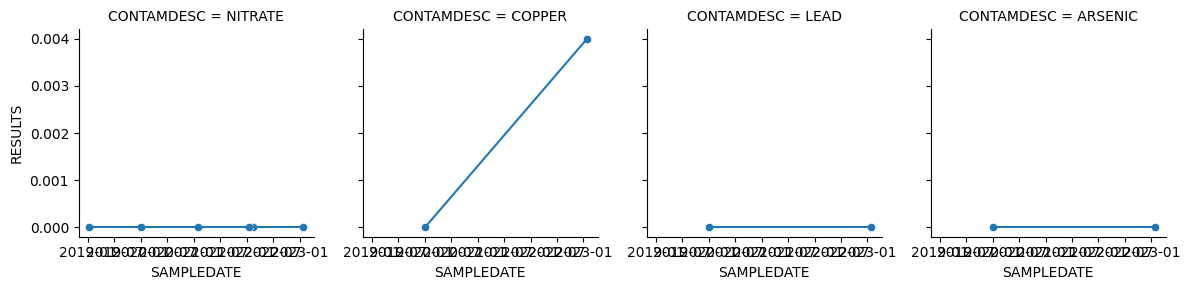

In [ ]:
# Create Seaborn FacetGrid
import seaborn as sns
import matplotlib.pyplot as plt
import branca

# A function to create a plot
def create_plot(dataframe):
#fig, ax = plt.subplots()
    plot = sns.FacetGrid(data=dataframe, col="CONTAMDESC")
#set(ylim=(0,0.5))
#x = df_list[0]["SAMPLEDATE"]
#y = df_list[0]["RESULTS"]

    plot.map(sns.lineplot, "SAMPLEDATE", "RESULTS")
    plot.map(sns.scatterplot, "SAMPLEDATE", "RESULTS")


#for i, txt in enumerate(y):
#    plt.annotate(txt, (x[i], y[i]))
    return plot

test_plot = create_plot(df_list[0])

# Pass data for each PWSID testing location to create_plot function
#plots = [create_plot(frame) for frame in df_list]

# Initialize map where location is center of Palm Beach County
map = folium.Map(location=(26.6515,-80.2767), zoom_start=10)

# Add markers for PWSID testing locations to map
for i in range(0, marker_locations.shape[0]):
    folium.Marker(
        location=(marker_locations.iloc[i]["Latitude"], marker_locations.iloc[i]["Longitude"]),
        popup=[test_plot]
    ).add_to(map)

map

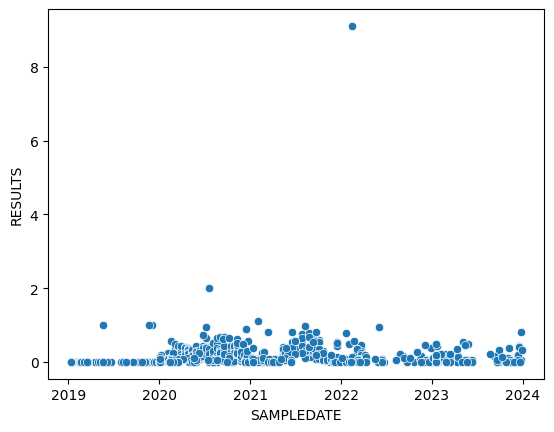

In [ ]:
# Line plot of all contaminants over time across county
# Create seaborn plot
nit_plot = sns.scatterplot(data=(data_merged[data_merged["CONTAMDESC"] == "NITRATE"]), x="SAMPLEDATE", y="RESULTS")

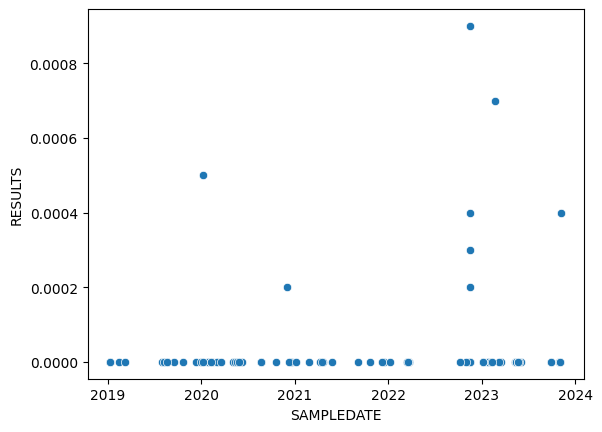

In [ ]:
ars_plot = sns.scatterplot(data=(data_merged[data_merged["CONTAMDESC"] == "ARSENIC"]), x="SAMPLEDATE", y="RESULTS")

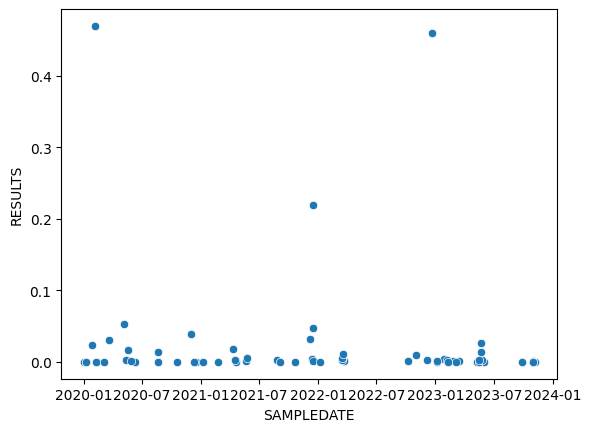

In [ ]:
cop_plot = sns.scatterplot(data=(data_merged[data_merged["CONTAMDESC"] == "COPPER"]), x="SAMPLEDATE", y="RESULTS")

In [ ]:
import numpy as np

np.arange(data_merged["RESULTS"].min(), data_merged["RESULTS"].max(), 0.01)

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  , 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09,
       1.1 , 1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2 ,
       1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3 , 1.31,
       1.32, 1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4 , 1.41, 1.42,
       1.43, 1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.

In [ ]:
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# Create new dataframe for contaminant lead only
lead_data = data_merged[data_merged["CONTAMDESC"] == "LEAD"]

# Create category column based on how results relate to EPA goals and violation standards
def safety_cat(result, mcl, mclg):
    if result <= mclg:
        return "Goal met"
    if mclg < result < mcl:
        return "Within legal limit" 
    if mcl < result:
        return "Violation"


# Apply above fuction to RESULTS, EPA_MCL, and EPA_MCLG columns to create new column SAFETYCAT
lead_data["SAFETYCAT"] = (lead_data["RESULTS"], lead_data["EPA_MCL"], lead_data["EPA_MCLG"]).apply(safety_cat)
lead_data.head()

# @interact
# def results_per_year(
#     min_result = np.arange(data_merged["RESULTS"].min(), data_merged["RESULTS"].max(), 0.01),
#     max_result = np.arange(data_merged["RESULTS"].min(), data_merged["RESULTS"].max(), 0.01)):

#     condition = (data_merged["RESULTS"] > min_result) & (data_merged["RESULTS"] < max_result)

#     plt.figure()
#     lea_plot = sns.scatterplot(data=(lead_data[condition]), x="SAMPLEDATE", y="RESULTS")


interactive(children=(Dropdown(description='min_result', options=(0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.0…

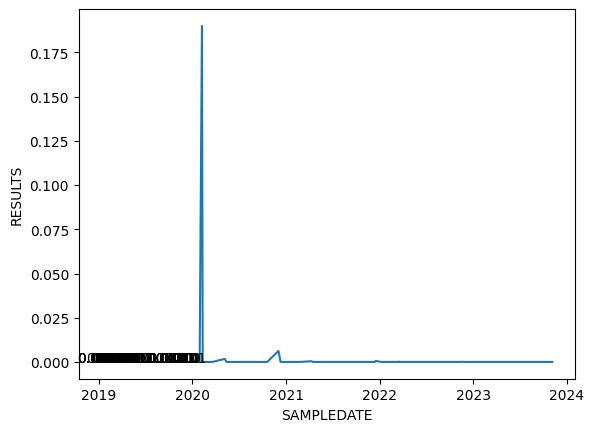

In [39]:
plt.figure()
lea_plot = sns.lineplot(data=(data_merged[data_merged["CONTAMDESC"] == "LEAD"]), x="SAMPLEDATE", y="RESULTS")
for i, label in enumerate(data_merged[data_merged["CONTAMDESC"] == "LEAD"]["RESULTS"]):
    plt.annotate(label, (data_merged["SAMPLEDATE"][i], data_merged["RESULTS"][i]), ha='center')

In [ ]:
data_merged[data_merged["CONTAMDESC"] == "LEAD"]["RESULTS"].unique()